In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *

**Created function that prepares the initial state of the qubit. In this case we prepare it in the singlet state**

In [3]:
def prepareState(circ, q, c):
    #Singlet state
    circ.h(1)
    circ.cx(q[1], q[0])
    circ.x(0)
    circ.z(1)
    return circ

In [4]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = QuantumCircuit(q, c)
circ = prepareState(circ, q, c)

simulator = Aer.get_backend('qasm_simulator')

# Bit Flip Error and Custom "Phase Flip Error"

In [5]:
# Example error probabilities
p_reset = 0.1
p_meas = 0.05
p_gate1 = 0.05

# QuantumError objects
error_resetX = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_measX = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1X = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2X = error_gate1X.tensor(error_gate1X)

# Add errors to noise model
noise_bitflip = NoiseModel()
noise_bitflip.add_all_qubit_quantum_error(error_resetX, "reset")
noise_bitflip.add_all_qubit_quantum_error(error_measX, "measure")
noise_bitflip.add_all_qubit_quantum_error(error_gate1X, ["u1", "u2", "u3"])
noise_bitflip.add_all_qubit_quantum_error(error_gate2X, ["cx"])

print(noise_bitflip)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'measure', 'u1', 'reset', 'u3']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


**Plotting the histogram for the bit flip error**

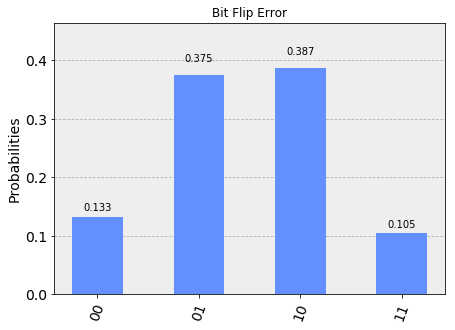

In [6]:
# Run the noisy simulation
circ.measure(q, c)
job = execute(circ, simulator, basis_gates=noise_bitflip.basis_gates, noise_model=noise_bitflip)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip, title='Bit Flip Error')

**Creating noise model for phase flip with same probabilities as bit flip**

In [7]:
#Using the same probabilities
noise_phase = NoiseModel()
#QuantumError objects
error_gate1Z = pauli_error([('Z', p_gate1), ('I', 1 - p_gate1)])
error_gate2Z = error_gate1Z.tensor(error_gate1Z)

noise_phase.add_all_qubit_quantum_error(error_gate1Z, ["u1", "u2", "u3"])
noise_phase.add_all_qubit_quantum_error(error_gate2X, ["cx"])

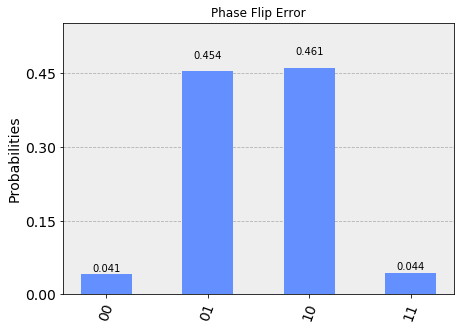

In [8]:
# Run the noisy simulation
circ.measure(q, c)
job = execute(circ, simulator, basis_gates=noise_phase.basis_gates, noise_model=noise_phase)
result_phase_flip = job.result()
counts_phase_flip = result_phase_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_phase_flip, title="Phase Flip Error")

# Thermal Relaxation: 

In [11]:
circ = QuantumCircuit(q, c)
circ = prepareState(circ, q, c)

thermalCounts = []
timeStep = 100
rangeVal = 100
# for i in range(rangeVal):
# T1 and T2 values for qubits 0-3
T1s = [30e3] # Is a bell curve with the center at the first parameter with a distribution of the second parameter
T2s = [2 * T1s]  # same thing

# Truncate random T2s <= T1s
#T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 14978.66136777  # 1 microsecond
time_measure = timeStep # 1 microsecond # was originally 1000

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
circ.measure(q, c)
#print(noise_thermal)
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result_thermal()
counts_thermal = result_thermal.get_counts(0)
# Plot noisy output
#plot_histogram(counts_thermal)
thermalCounts.append(counts_thermal)
plot_histogram(counts_thermal, title="Thermal Relaxation Error")

    
#print(thermalCounts)
#######This will prove the relationship between time waited to measure and the state of the qubit#######
# xPoints = []
# yPoints = []
# for i in range(len(thermalCounts)):
#     xPoints.append(i*timeStep)
#     yPoints.append(thermalCounts[i].get('0', 0)/(thermalCounts[i].get('0', 0) + thermalCounts[i].get('1', 0)))

# print(xPoints)
# print(yPoints)



TypeError: '<=' not supported between instances of 'list' and 'int'

**Plotting the temperature-time relationship**

As a fun side experiment I decided to plot the influence of temperature relaxation on a single qubit (how close the qubit is to it's 0 or 1 state) after a certian amount of time. Currently it is commented out but before I made a plot that showed that the state would increase quickly to the 0 state and then level off.


**Info about the graph**

1.0 = |0> state and 0.0 = |1> state

Time is measured in microseconds

In [ ]:
# plt.plot(xPoints, yPoints, 'ro')
# plt.axis([0, rangeVal * timeStep, 0, 1])
# plt.show()

# Depolarization

In [ ]:
circ = QuantumCircuit(q, c)
circ = prepareState(circ, q, c)
circ.measure(q, c)

noiseDepolarising = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0 
error = depolarizing_error(0.3, 1)
noiseDepolarising.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])


# Print noise model info
#print(noiseDepolarising)

job = execute(circ, simulator, basis_gates=noiseDepolarising.basis_gates, noise_model=noiseDepolarising)
result_depolarize = job.result()
counts_depolarize = result_depolarize.get_counts(0)
#print(counts_depolarize)
plot_histogram(counts_depolarize, title="Depolarization Error")

# Amplitude Damping

In [ ]:
circ = QuantumCircuit(q, c)
circ = prepareState(circ, q, c)
circ.measure(q, c)

amplitudeNoise = NoiseModel()

# Add amplitude error on qubit 2 foxxtrall single qubit u1, u2, u3 gates on qubit 0 
error = amplitude_damping_error(0.05, 0, True)
amplitudeNoise.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(amplitudeNoise)

job = execute(circ, simulator, basis_gates=amplitudeNoise.basis_gates, noise_model=amplitudeNoise)
result_ampl = job.result()
counts_ampl = result_ampl.get_counts(0)
print(counts_ampl)
plot_histogram(counts_ampl, title="Amplitude Damping Error")

# Phase Damping

In [ ]:
circ = QuantumCircuit(q, c)
circ = prepareState(circ, q, c)
circ.ry(-np.pi/2, 0)
circ.ry(-np.pi/2, 1)
circ.measure(q, c)

phaseDamp = NoiseModel()

# Add amplitude error on qubit 2 foxxtrall single qubit u1, u2, u3 gates on qubit 0 
error = phase_damping_error(0.3, 0)
phaseDamp.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(phaseDamp)

job = execute(circ, simulator, basis_gates=phaseDamp.basis_gates, noise_model=phaseDamp)
result_damp = job.result()
counts_damp = result_damp.get_counts(0)
print(counts_damp)
plot_histogram(counts_damp, title="Phase Damping Error")